### Attack simulation

This notebook includes both basic environment set-up and the attack simulation.

In [1]:
import pybullet as p
import pybullet_data
import numpy as np
import time

# Start PyBullet GUI
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.8)

# Load plane and robot
p.loadURDF("plane.urdf")
robot = p.loadURDF("r2d2.urdf", [0, 0, 0.1])

# Add a cube obstacle in front of the robot at height z=1.0 to match ray height
p.loadURDF("cube.urdf", basePosition=[2, 0, 1.0])


pybullet build time: Apr 20 2025 22:34:44


2

In [2]:
# Raycasting setup
num_rays = 60
ray_len = 3.0
ray_z = 1.0
origin_offset = 0.3

ray_from = []
ray_to = []

for i in range(num_rays):
    angle = 2 * np.pi * i / num_rays
    ox = origin_offset * np.cos(angle)
    oy = origin_offset * np.sin(angle)
    ray_from.append([ox, oy, ray_z])
    ray_to.append([
        ox + ray_len * np.cos(angle),
        oy + ray_len * np.sin(angle),
        ray_z
    ])

# Spoofed ray indices
spoof_indices = range(10, 15)

# Logging structures
frame_hit_distances = []
frame_hit_labels = []

# Run simulation
for step in range(300):
    p.removeAllUserDebugItems()
    results = p.rayTestBatch(ray_from, ray_to)

    distances_this_frame = []
    labels_this_frame = []

    for i, res in enumerate(results):
        spoofed = i in spoof_indices

        if spoofed:
            angle = 2 * np.pi * i / num_rays
            hit_pos = [
                ray_from[i][0] + 0.5 * np.cos(angle),
                ray_from[i][1] + 0.5 * np.sin(angle),
                ray_z
            ]
            color = [1, 0, 0]  # red
            distances_this_frame.append(0.5)
            labels_this_frame.append("spoofed")
            print(f"[RED] Ray {i:02d} spoofed to distance: {dist:.2f} m")
        elif res[0] >= 0:
            hit_pos = res[3]
            color = [0, 1, 0]  # green
            dist = np.linalg.norm(np.array(hit_pos) - np.array(ray_from[i]))
            distances_this_frame.append(dist)
            labels_this_frame.append("real")
            print(f"[GREEN] Ray {i:02d} hit body ID {res[0]} at distance: {dist:.2f} m")
        else:
            hit_pos = ray_to[i]
            color = [0.5, 0.5, 0.5]  # gray
            distances_this_frame.append(-1)
            labels_this_frame.append("none")
            print(f"[GRAY] Ray {i:02d} missed")

        p.addUserDebugLine(ray_from[i], hit_pos, color, lineWidth=1, lifeTime=1.0)

    frame_hit_distances.append(distances_this_frame)
    frame_hit_labels.append(labels_this_frame)

    time.sleep(0.05)


In [5]:
import pandas as pd

df = pd.DataFrame({
    'Ray': np.arange(num_rays),
    'Distance': frame_hit_distances[-1],
    'Label': frame_hit_labels[-1]
})
df.to_csv("spoofed_lidar_snapshot.csv", index=False)


In [3]:
import matplotlib.pyplot as plt

# Use the final frame from Cell 2
hit_distances = np.array(frame_hit_distances[-1])
hit_labels = np.array(frame_hit_labels[-1])
ray_indices = np.arange(len(hit_distances))

# Masks for plotting
real_mask = hit_labels == "real"
spoofed_mask = hit_labels == "spoofed"
missed_mask = hit_labels == "none"

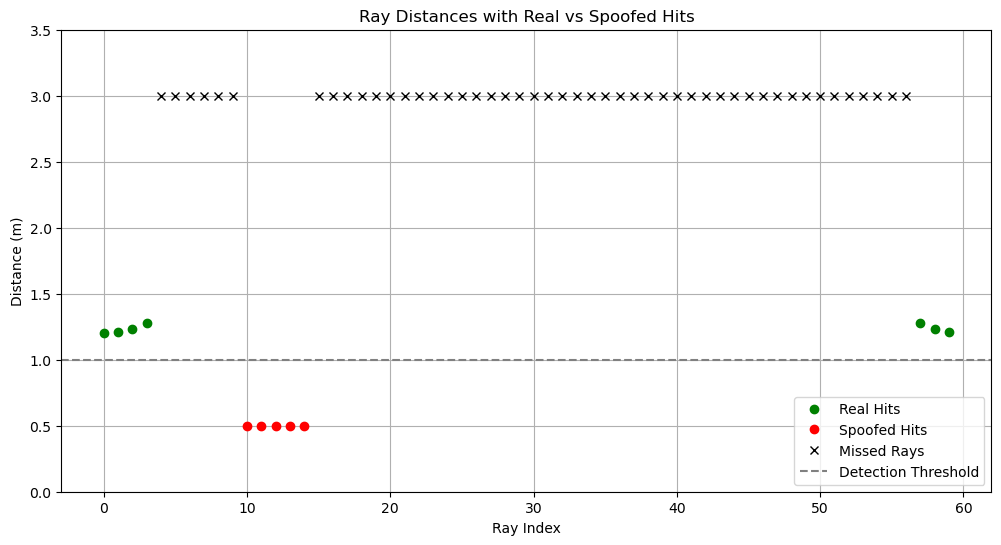

=== Distance Summary ===
Ray 00: ✅ Real hit at 1.20 m
Ray 01: ✅ Real hit at 1.21 m
Ray 02: ✅ Real hit at 1.23 m
Ray 03: ✅ Real hit at 1.28 m
Ray 04: ❌ Missed
Ray 05: ❌ Missed
Ray 06: ❌ Missed
Ray 07: ❌ Missed
Ray 08: ❌ Missed
Ray 09: ❌ Missed
Ray 10: 🚨 Spoofed at 0.50 m
Ray 11: 🚨 Spoofed at 0.50 m
Ray 12: 🚨 Spoofed at 0.50 m
Ray 13: 🚨 Spoofed at 0.50 m
Ray 14: 🚨 Spoofed at 0.50 m
Ray 15: ❌ Missed
Ray 16: ❌ Missed
Ray 17: ❌ Missed
Ray 18: ❌ Missed
Ray 19: ❌ Missed
Ray 20: ❌ Missed
Ray 21: ❌ Missed
Ray 22: ❌ Missed
Ray 23: ❌ Missed
Ray 24: ❌ Missed
Ray 25: ❌ Missed
Ray 26: ❌ Missed
Ray 27: ❌ Missed
Ray 28: ❌ Missed
Ray 29: ❌ Missed
Ray 30: ❌ Missed
Ray 31: ❌ Missed
Ray 32: ❌ Missed
Ray 33: ❌ Missed
Ray 34: ❌ Missed
Ray 35: ❌ Missed
Ray 36: ❌ Missed
Ray 37: ❌ Missed
Ray 38: ❌ Missed
Ray 39: ❌ Missed
Ray 40: ❌ Missed
Ray 41: ❌ Missed
Ray 42: ❌ Missed
Ray 43: ❌ Missed
Ray 44: ❌ Missed
Ray 45: ❌ Missed
Ray 46: ❌ Missed
Ray 47: ❌ Missed
Ray 48: ❌ Missed
Ray 49: ❌ Missed
Ray 50: ❌ Missed
Ray 5

In [4]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(ray_indices[real_mask], hit_distances[real_mask], 'go', label='Real Hits')
plt.plot(ray_indices[spoofed_mask], hit_distances[spoofed_mask], 'ro', label='Spoofed Hits')
plt.plot(ray_indices[missed_mask], [3.0]*np.sum(missed_mask), 'kx', label='Missed Rays')
plt.axhline(1.0, color='gray', linestyle='--', label='Detection Threshold')

plt.title("Ray Distances with Real vs Spoofed Hits")
plt.xlabel("Ray Index")
plt.ylabel("Distance (m)")
plt.legend()
plt.grid(True)
plt.ylim(0, 3.5)
plt.show()

# Print a table
print("=== Distance Summary ===")
for i in range(len(hit_distances)):
    label = hit_labels[i]
    dist = hit_distances[i]
    if label == "none":
        print(f"Ray {i:02d}: ❌ Missed")
    elif label == "spoofed":
        print(f"Ray {i:02d}: 🚨 Spoofed at {dist:.2f} m")
    else:
        print(f"Ray {i:02d}: ✅ Real hit at {dist:.2f} m")

#### research countermeasure

Below is just some effors of researching countermeasures, dont have to run them (I just want to keep them to record some of my efforts.)

In [ ]:
#updated cell of ray condions
#try to develop detection and countermeasure method
# Detection parameters
window = 2                # Neighborhood window size
anomaly_threshold = 0.4   # Deviation threshold for anomaly detection

for step in range(300):
    p.removeAllUserDebugItems()
    results = p.rayTestBatch(ray_from, ray_to)

    distances_this_frame = []
    labels_this_frame = []

    for i, res in enumerate(results):
        spoofed = i in spoof_indices  # for simulation only

        # Inject spoofed fake hit
        if spoofed:
            angle = 2 * np.pi * i / num_rays
            hit_pos = [
                ray_from[i][0] + 0.5 * np.cos(angle),
                ray_from[i][1] + 0.5 * np.sin(angle),
                ray_z
            ]
            dist = 0.5
            distances_this_frame.append(dist)
            label = "sim_spoof"  # only for later comparison
            print(f"[RED] Ray {i:02d} spoofed to distance: {dist:.2f} m")
        elif res[0] >= 0:
            hit_pos = res[3]
            dist = np.linalg.norm(np.array(hit_pos) - np.array(ray_from[i]))

            # === Real detection rule starts here ===
            # Look at neighbors to detect anomalies
            neighbors = []
            for j in range(max(0, i - window), min(num_rays, i + window + 1)):
                if j != i:
                    result_j = results[j]
                    if j in spoof_indices:
                        continue  # skip spoofed values for neighborhood check
                    if result_j[0] >= 0:
                        neighbor_hit = result_j[3]
                        neighbor_dist = np.linalg.norm(np.array(neighbor_hit) - np.array(ray_from[j]))
                        neighbors.append(neighbor_dist)
            if neighbors:
                local_avg = np.mean(neighbors)
                if abs(dist - local_avg) > anomaly_threshold:
                    label = "detected"
                    color = [1, 1, 0]
                    print(f"[YELLOW] Ray {i:02d} flagged as spoofed (dev {abs(dist - local_avg):.2f})")
                else:
                    label = "real"
                    color = [0, 1, 0]
                    print(f"[GREEN] Ray {i:02d} real hit at distance: {dist:.2f} m")
            else:
                label = "real"
                color = [0, 1, 0]
        else:
            hit_pos = ray_to[i]
            dist = -1
            label = "none"
            color = [0.5, 0.5, 0.5]
            print(f"[GRAY] Ray {i:02d} missed")

        # Draw ray
        p.addUserDebugLine(ray_from[i], hit_pos, color, lineWidth=1, lifeTime=1.0)

        distances_this_frame.append(dist)
        labels_this_frame.append(label)

    frame_hit_distances.append(distances_this_frame)
    frame_hit_labels.append(labels_this_frame)

    time.sleep(0.05)


In [ ]:
# === Step 1: Load latest frame from Cell 2 ===
# before plottting
hit_distances = np.array(frame_hit_distances[-1])
hit_labels = np.array(frame_hit_labels[-1])
ray_indices = np.arange(len(hit_distances))
num_rays = len(hit_distances)

In [ ]:
def clean_lidar(distances, labels, replace_strategy='mean', window=2, default_value=3.0):
    """
    Replace suspicious values ('detected', 'none') with cleaner approximations.
    """
    filtered = distances.copy()

    for i in range(len(distances)):
        if labels[i] in ['detected', 'none']:
            neighbors = []
            for j in range(max(0, i - window), min(len(distances), i + window + 1)):
                if j != i and labels[j] == 'real' and distances[j] > 0:
                    neighbors.append(distances[j])

            if replace_strategy == 'mean':
                filtered[i] = np.mean(neighbors) if neighbors else default_value
            elif replace_strategy == 'median':
                filtered[i] = np.median(neighbors) if neighbors else default_value
            elif replace_strategy == 'max':
                filtered[i] = default_value
            elif replace_strategy == 'drop':
                filtered[i] = np.nan  # NaN for matplotlib to skip
    return filtered


In [ ]:
filtered = clean_lidar(hit_distances, hit_labels, replace_strategy='mean')


In [ ]:
plt.figure(figsize=(12, 6))

# Raw and filtered lines
plt.plot(ray_indices, hit_distances, 'k.', alpha=0.4, label='Raw Distances')
plt.plot(ray_indices, filtered, 'b.-', label='Filtered Distances')

# Highlights
spoofed_mask = hit_labels == 'sim_spoof'
detected_mask = hit_labels == 'detected'
missed_mask = hit_labels == 'none'

plt.plot(ray_indices[spoofed_mask], hit_distances[spoofed_mask], 'ro', label='Simulated Spoofed')
plt.plot(ray_indices[detected_mask], hit_distances[detected_mask], 'yo', label='Detected as Spoofed')
plt.plot(ray_indices[missed_mask], [3.0]*np.sum(missed_mask), 'kx', label='Missed Rays')

plt.axhline(1.0, linestyle='--', color='gray', label='Detection Threshold')
plt.title("LiDAR Readings: Raw vs Filtered (with Detection & Countermeasure)")
plt.xlabel("Ray Index")
plt.ylabel("Distance (m)")
plt.ylim(0, 3.5)
plt.grid(True)
plt.legend()
plt.show()
